In [1]:
# Imports necesarios.
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import numpy as np
import re
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron
from pmdarima import auto_arima
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense

### Inciso 4:.Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como conjunto de prueba

In [2]:
data = pd.read_csv('cons.csv')
# Primero, asegúrate de que la columna 'Fecha' sea de tipo datetime.date

print(data.columns.dtype)

object


In [3]:
def count_zeros_per_column(dataframe):
    zero_counts = dataframe.apply(lambda column: (column == 0).sum())
    return zero_counts

# Suponiendo que 'data' es tu DataFrame con los datos de 2020 al 2022
zero_counts = count_zeros_per_column(data)

# Imprimir la cantidad de ceros por columna en el formato deseado
for column_name, count in zero_counts.items():
    print(f"{column_name.ljust(27)} {count}")


Fecha                       0
Aceites lubricantes         228
Asfalto                     0
Bunker                      0
Ceras                       260
Combustible turbo jet       60
Diesel bajo azufre          216
Diesel ultra bajo azufre    216
Gas licuado de petróleo     0
Gasolina de aviación        1
Gasolina regular            0
Gasolina superior           0
Grasas lubricantes          228
Kerosina                    0
Mezclas oleosas             241
Naftas                      228
PetCoke                     49
Petróleo crudo              24
Solventes                   228
Butano                      234
Diesel alto azufre          65
Orimulsión                  253
Total                       0


In [7]:
# Definir la lista de columnas a eliminar
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Diesel bajo azufre', 'Diesel ultra bajo azufre',
                   'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión', 'Kerosina']

# Eliminar las columnas con más de 200 datos faltantes
data.drop(columns=columns_to_drop, inplace=True)

# Llenar las columnas numéricas restantes con la media
numeric_columns = data.select_dtypes(include=[pd.np.number]).columns
for col in numeric_columns:
    col_mean = data[col].mean()
    data[col].fillna(col_mean, inplace=True)
    data[col].replace(0, col_mean, inplace=True)

# Imprimir el DataFrame modificado
print(data)


          Fecha   Asfalto     Bunker  Combustible turbo jet  \
0    2000-01-01  48446.00  296766.99           35953.793274   
1    2000-02-01  50597.00  328116.44           35953.793274   
2    2000-03-01  27593.00  368589.63           35953.793274   
3    2000-04-01  53794.00  396300.47           35953.793274   
4    2000-05-01  60137.00  449368.92           35953.793274   
..          ...       ...        ...                    ...   
276  2023-01-01  77035.87  105294.71           73581.220000   
277  2023-02-01  74416.24  116577.42           66761.160000   
278  2023-03-01  69630.40  194492.83           83431.510000   
279  2023-04-01  74654.67  157844.83           80733.640000   
280  2023-05-01  76296.87  221002.66           73860.950000   

     Gas licuado de petróleo  Gasolina de aviación  Gasolina regular  \
0              194410.476190               1426.00         202645.20   
1              174710.552381               1458.00         205530.96   
2              189234.06666

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\1684987919.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  numeric_columns = data.select_dtypes(include=[pd.np.number]).columns


In [9]:
data['Fecha'] = pd.to_datetime(data['Fecha']).dt.date

train_data = data[(data['Fecha'] >= pd.to_datetime('2020-01-01').date()) & (data['Fecha'] <= pd.to_datetime('2022-12-31').date())]
test_data = data[data['Fecha'] >= pd.to_datetime('2023-01-01').date()]

train_data
test_data

,Fecha,Asfalto,Bunker,Combustible turbo jet,Gas licuado de petróleo,Gasolina de aviación,Gasolina regular,Gasolina superior,PetCoke,Petróleo crudo,Diesel alto azufre,Total
276,2023-01-01,77035.87,105294.71,73581.22,574148.00,1224.04,804524.73,599501.29,427535.42,112435.87,592592.719087,4112993.69
277,2023-02-01,74416.24,116577.42,66761.16,497273.19,1134.43,737345.64,544144.00,311098.09,100237.67,592592.719087,3728618.58
278,2023-03-01,69630.40,194492.83,83431.51,588892.16,1514.78,875010.34,656941.64,311475.22,112090.14,592592.719087,4412648.89
279,2023-04-01,74654.67,157844.83,80733.64,513919.89,1390.03,798128.36,585642.20,322290.11,96434.73,592592.719087,3924688.62
280,2023-05-01,76296.87,221002.66,73860.95,565814.79,1790.83,866826.79,646221.20,508981.62,114448.93,592592.719087,4473315.73


In [11]:
# Escalar los datos
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.drop(['Fecha'], axis=1))
test_data_scaled = scaler.transform(test_data.drop(['Fecha'], axis=1))
train_data_scaled

array([[0.        , 0.70436094, 0.66611124, 0.35915471, 0.66437909,
        0.44569771, 0.61551093, 0.28864283, 0.13522945, 0.        ,
        0.55929771],
       [0.17320324, 0.81756613, 0.55727727, 0.38234421, 0.50814567,
        0.47519051, 0.64393308, 0.19427523, 0.60686294, 0.        ,
        0.5993408 ],
       [0.11135151, 0.46266193, 0.29160353, 0.354375  , 0.49779506,
        0.2826638 , 0.31860776, 0.2873443 , 0.6351707 , 0.        ,
        0.39886963],
       [0.07608896, 0.        , 0.        , 0.        , 0.06807052,
        0.        , 0.0074388 , 0.2945653 , 0.        , 0.        ,
        0.        ],
       [0.38027027, 0.76077925, 0.04865866, 0.0808988 , 0.00594073,
        0.04994956, 0.04887171, 0.38479652, 0.3358249 , 0.        ,
        0.12120869],
       [0.3514914 , 0.54950537, 0.04373291, 0.2685315 , 0.07720342,
        0.14361403, 0.        , 0.32138448, 0.20727098, 0.        ,
        0.08782516],
       [0.52158984, 0.59115109, 0.06582053, 0.36714082, 0.

In [22]:
# Definir el número de pasos de tiempo y características
sequence_length = 1
num_features = train_data_scaled.shape[1]  # El número de columnas en train_data_scaled


In [24]:
# Crear secuencias de entrenamiento y etiquetas
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Imprimir las dimensiones de las secuencias y etiquetas de entrenamiento y prueba
print("Dimensiones de entrenamiento:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("Dimensiones de prueba:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Dimensiones de entrenamiento:
X_train: (35, 1, 11)
y_train: (35, 11)
Dimensiones de prueba:
X_test: (4, 1, 11)
y_test: (4, 11)


In [25]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_features))  # Salida con el mismo número de características
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), run_eagerly=True)

In [27]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
2/2 [==============================] - 0s 105ms/step - loss: 0.0286 - val_loss: 0.0848
Epoch 2/100
2/2 [==============================] - 0s 79ms/step - loss: 0.0291 - val_loss: 0.0862
Epoch 3/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0296 - val_loss: 0.0870
Epoch 4/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0299 - val_loss: 0.0865
Epoch 5/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0298 - val_loss: 0.0843
Epoch 6/100
2/2 [==============================] - 0s 74ms/step - loss: 0.0290 - val_loss: 0.0826
Epoch 7/100
2/2 [==============================] - 0s 81ms/step - loss: 0.0282 - val_loss: 0.0820
Epoch 8/100
2/2 [==============================] - 0s 76ms/step - loss: 0.0281 - val_loss: 0.0819
Epoch 9/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0282 - val_loss: 0.0818
Epoch 10/100
2/2 [==============================] - 0s 76ms/step - loss: 0.0282 - val_loss: 0.0813
Epoch 11/100
2/2 [

Epoch 84/100
2/2 [==============================] - 0s 74ms/step - loss: 0.0266 - val_loss: 0.0805
Epoch 85/100
2/2 [==============================] - 0s 72ms/step - loss: 0.0265 - val_loss: 0.0800
Epoch 86/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0265 - val_loss: 0.0795
Epoch 87/100
2/2 [==============================] - 0s 71ms/step - loss: 0.0264 - val_loss: 0.0792
Epoch 88/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0264 - val_loss: 0.0793
Epoch 89/100
2/2 [==============================] - 0s 76ms/step - loss: 0.0264 - val_loss: 0.0793
Epoch 90/100
2/2 [==============================] - 0s 85ms/step - loss: 0.0264 - val_loss: 0.0794
Epoch 91/100
2/2 [==============================] - 0s 72ms/step - loss: 0.0264 - val_loss: 0.0797
Epoch 92/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0263 - val_loss: 0.0803
Epoch 93/100
2/2 [==============================] - 0s 77ms/step - loss: 0.0264 - val_loss: 0.0810
Epoch 94/1

In [29]:
# Realizar predicciones y desescalar
predictions = model.predict(X_test)
predictions_descaled = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 40ms/step


In [39]:
# Suponiendo que 'scaler' es el objeto del escalador y 'y_test' es el conjunto de etiquetas de prueba

# Desescalar las predicciones y los valores reales
predictions_descaled = scaler.inverse_transform(predictions)
actual_values_descaled = scaler.inverse_transform(y_test)

# Imprimir las predicciones desescaladas y los valores reales desescalados
print("Comparación de Predicciones Desescaladas y Valores Reales Desescalados:")
for i in range(min(len(predictions_descaled), len(actual_values_descaled))):
    pred = predictions_descaled[i]
    actual = actual_values_descaled[i]
    diff = abs(pred - actual)
    print(f"Predicción: {pred}\tValor Real: {actual}\tDiferencia: {diff}")


Comparación de Predicciones Desescaladas y Valores Reales Desescalados:
Predicción: [6.8327312e+04 1.3849694e+05 9.8666938e+04 6.0089988e+05 1.3854586e+03
 9.0727675e+05 6.3771438e+05 4.9422262e+05 1.5333228e+05 5.9259262e+05
 4.2614045e+06]	Valor Real: [7.44162400e+04 1.16577420e+05 6.67611600e+04 4.97273190e+05
 1.13443000e+03 7.37345640e+05 5.44144000e+05 3.11098090e+05
 1.00237670e+05 5.92592719e+05 3.72861858e+06]	Diferencia: [6.08892750e+03 2.19195175e+04 3.19057775e+04 1.03626685e+05
 2.51028618e+02 1.69931110e+05 9.35703750e+04 1.83124535e+05
 5.30946113e+04 9.40871987e-02 5.32785920e+05]
Predicción: [6.2484426e+04 1.3187034e+05 8.5185609e+04 5.6828606e+05 1.2666006e+03
 8.5216375e+05 6.0709406e+05 4.3467325e+05 1.4479197e+05 5.9259269e+05
 4.0041875e+06]	Valor Real: [6.96304000e+04 1.94492830e+05 8.34315100e+04 5.88892160e+05
 1.51478000e+03 8.75010340e+05 6.56941640e+05 3.11475220e+05
 1.12090140e+05 5.92592719e+05 4.41264889e+06]	Diferencia: [7.14597422e+03 6.26224862e+04 1.

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


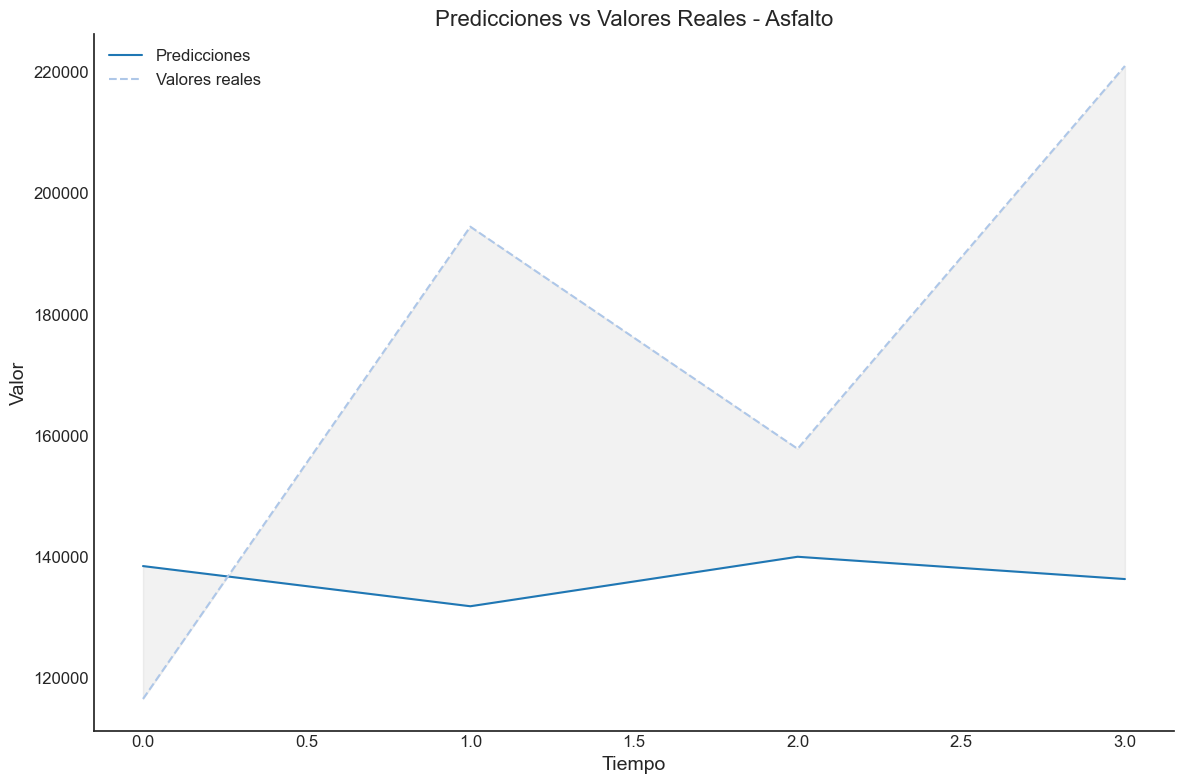

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


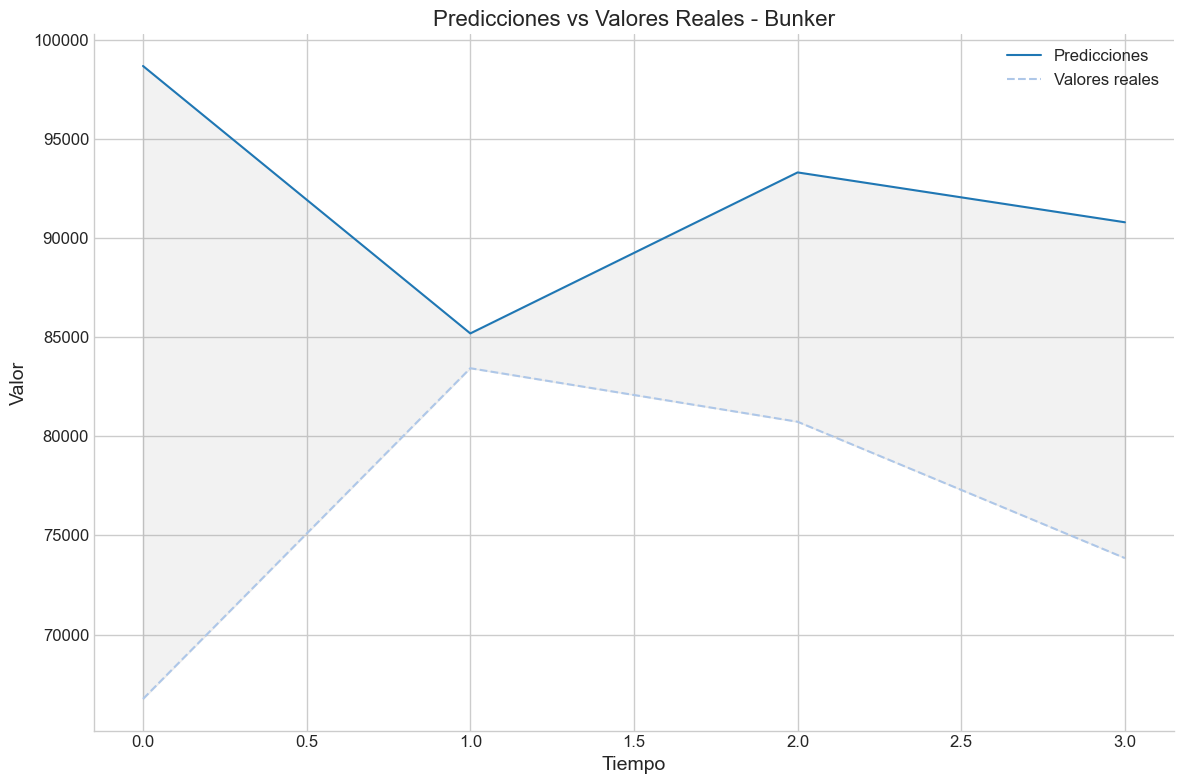

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


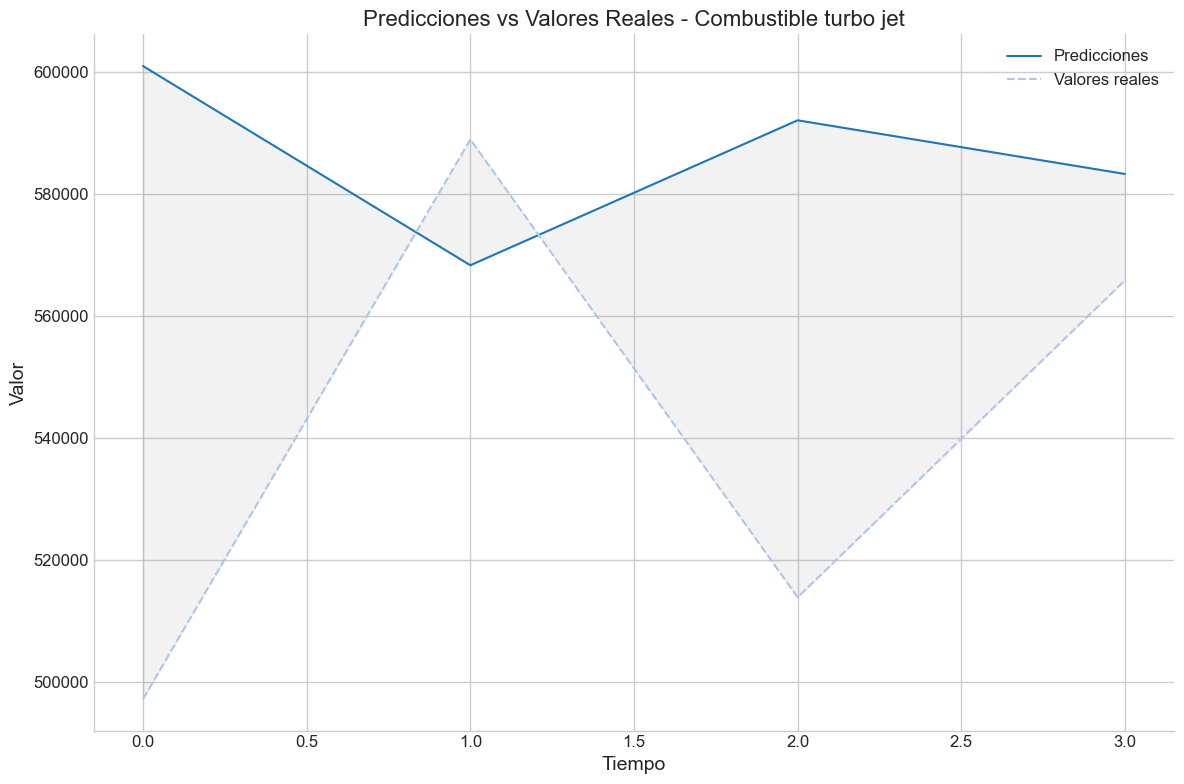

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


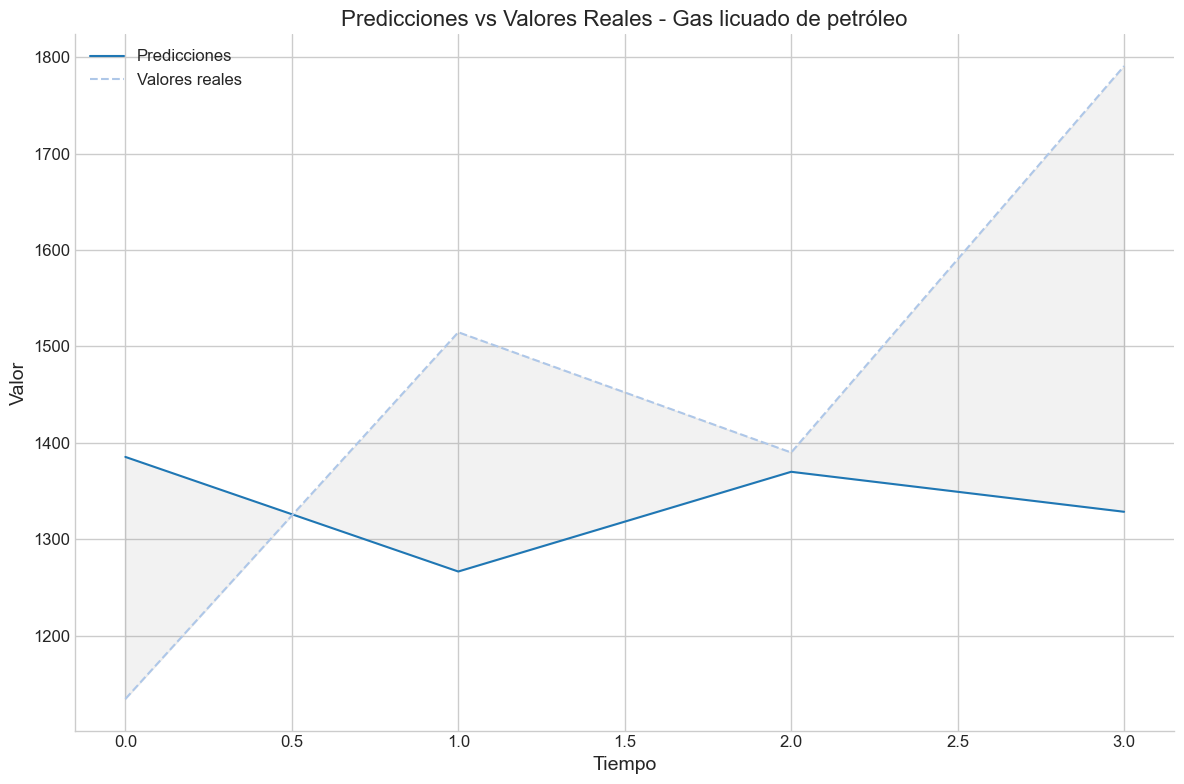

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


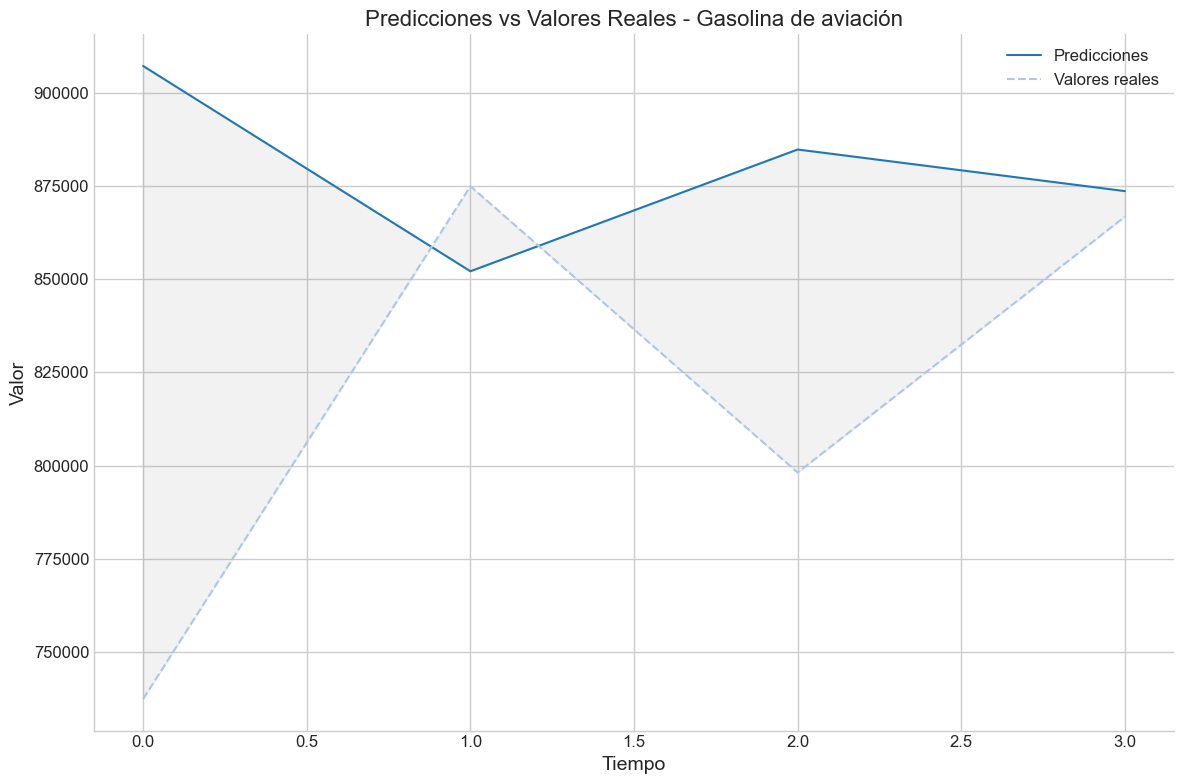

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


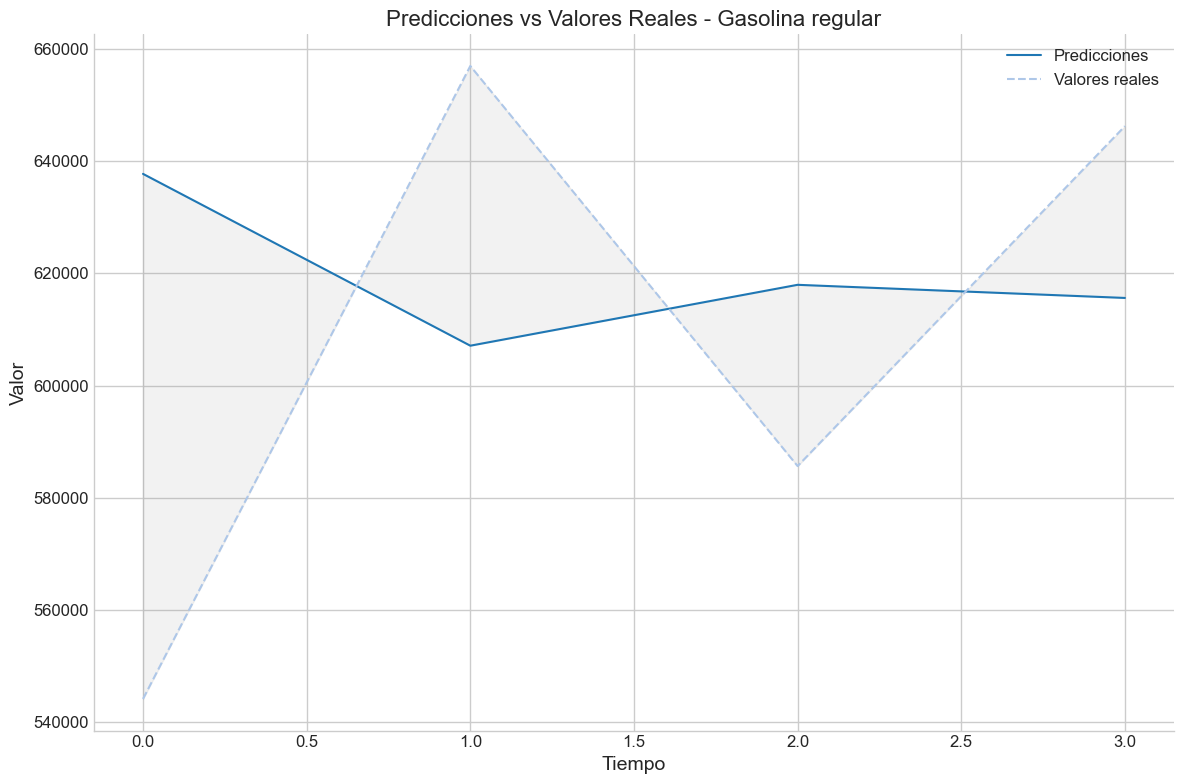

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


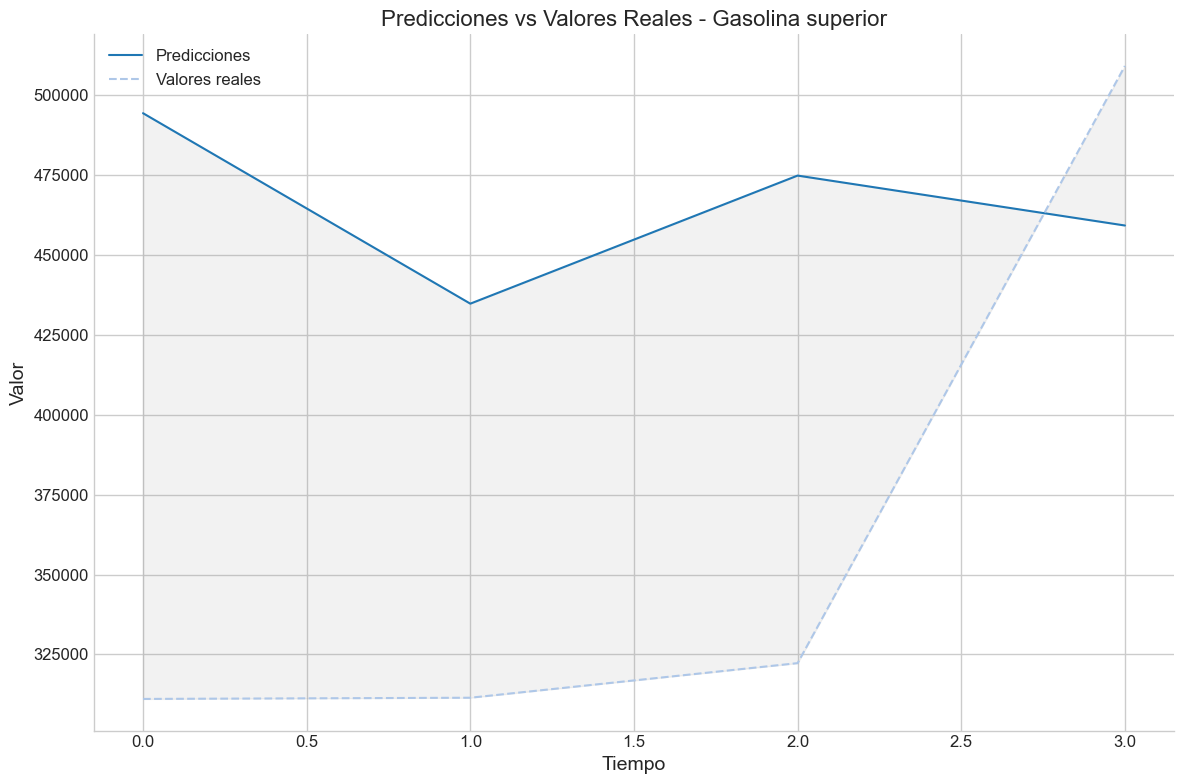

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


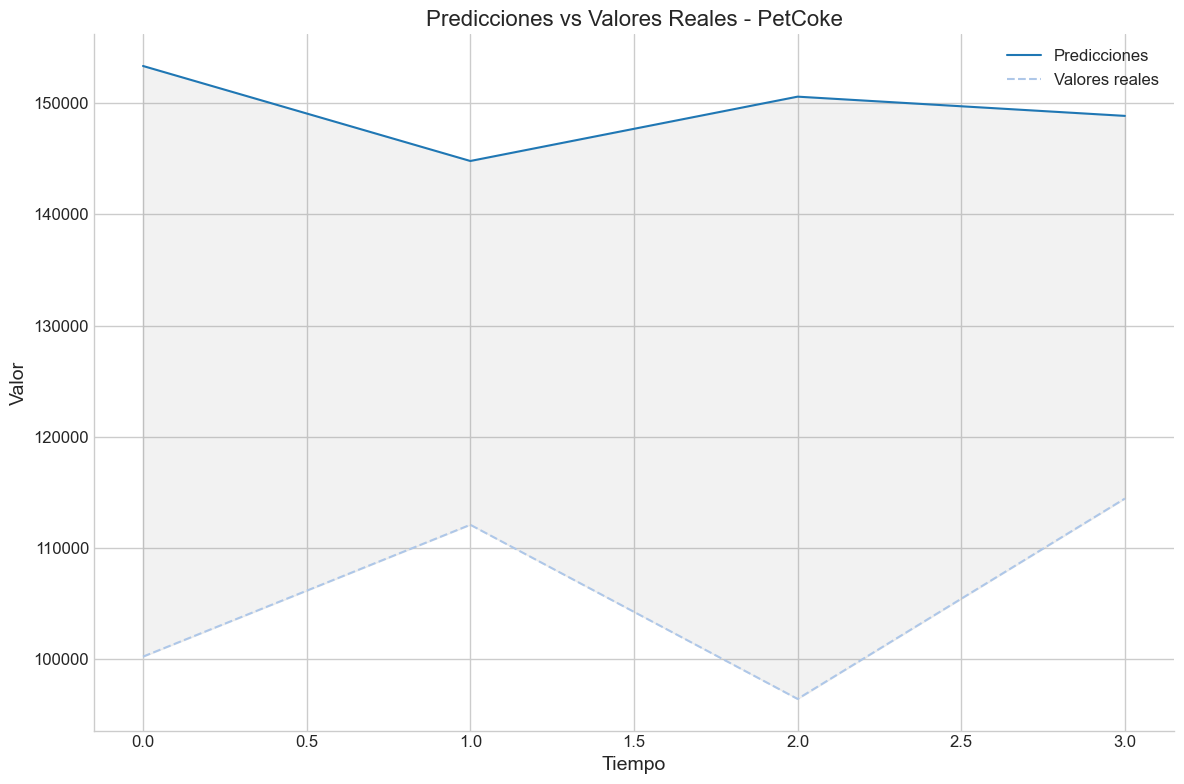

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


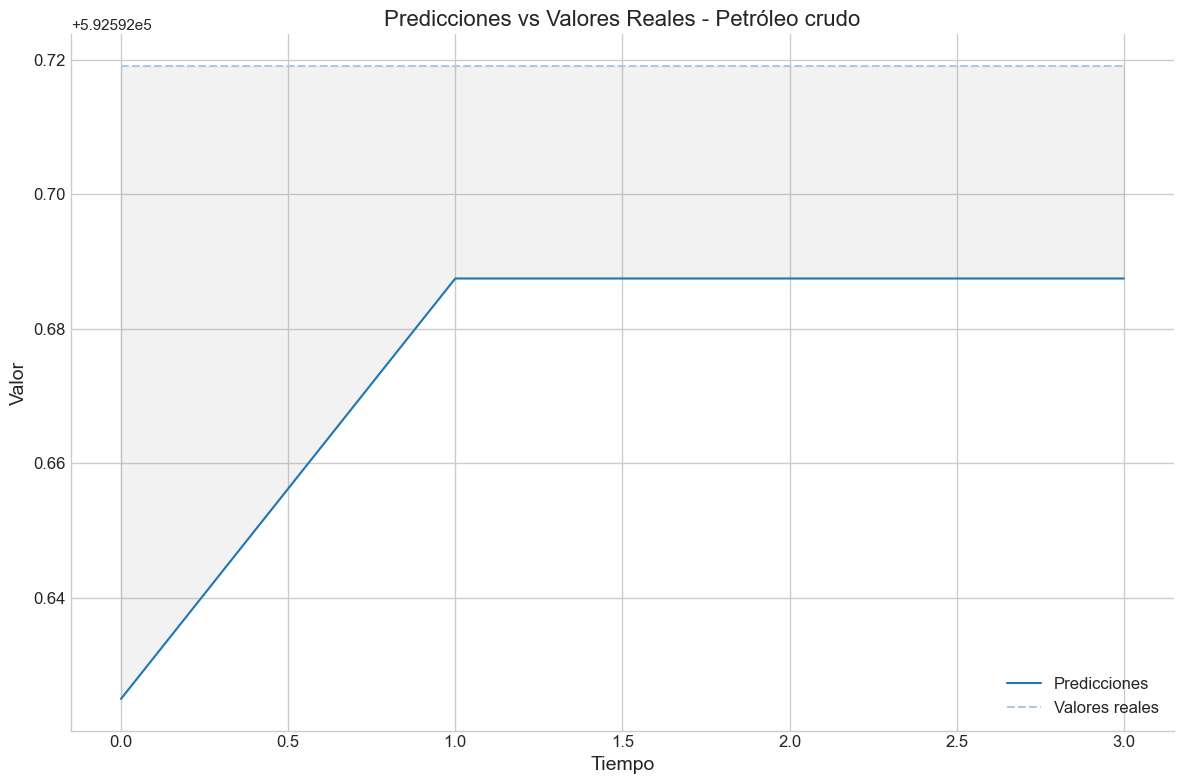

C:\Users\estef\AppData\Local\Temp\ipykernel_47808\2564849236.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


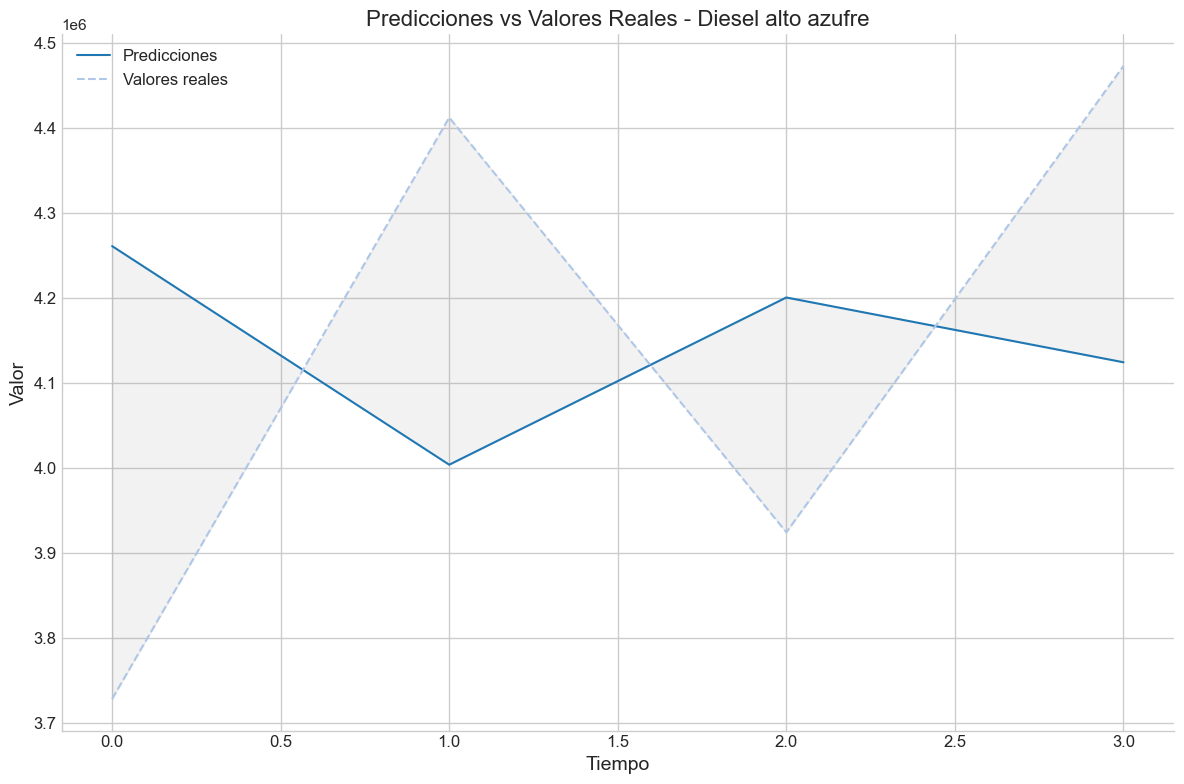

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un array con los índices de tiempo para el eje x
time_indices = np.arange(len(predictions_descaled))

# Nombre de las columnas de los tipos de gasolina
columnas_gasolina = ['Asfalto', 'Bunker', 'Combustible turbo jet', 'Gas licuado de petróleo',
                     'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
                     'PetCoke', 'Petróleo crudo', 'Diesel alto azufre']

columnas_gasolina_test = ['Gasolina regular']

# Colores llamativos
colors = plt.cm.tab20.colors

# Graficar las predicciones y los valores reales para cada tipo de gasolina en gráficas separadas [:, idx]
for i, columna in enumerate(columnas_gasolina):
    idx = data.columns.get_loc(columna)
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(time_indices, predictions_descaled[:, idx], label='Predicciones', color=colors[0])
    plt.plot(time_indices, scaler.inverse_transform(y_test)[:, idx], label='Valores reales', linestyle='dashed', color=colors[1])
    
    plt.xlabel('Tiempo', fontsize=14)
    plt.ylabel('Valor', fontsize=14)
    plt.title('Predicciones vs Valores Reales - ' + columna, fontsize=16)
    plt.legend(fontsize=12)
    
    # Estilo de fondo y cuadrícula
    plt.style.use('seaborn-whitegrid')
    
    # Quitar bordes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Añadir sombreado entre las curvas
    plt.fill_between(time_indices, predictions_descaled[:, idx], scaler.inverse_transform(y_test)[:, idx], color='gray', alpha=0.1)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [43]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Crear un DataFrame para almacenar las métricas por tipo de gasolina
metrics_data = pd.DataFrame(columns=['Tipo de gasolina', 'Error cuadrático medio (MSE)', 'Coeficiente de determinación (R2)'])

# Recorrer cada tipo de gasolina
for gasolina_column in columnas_gasolina:
    # Obtener el índice de la columna actual
    gasolina_idx = data.columns.get_loc(gasolina_column)
    
    # Obtener las predicciones y valores reales desescalados para la gasolina actual
    predictions_gasolina = predictions_descaled[:, gasolina_idx]
    y_test_gasolina = scaler.inverse_transform(y_test)[:, gasolina_idx]
    
    # Calcular el error cuadrático medio (MSE) y el coeficiente de determinación (R2)
    mse_gasolina = mean_squared_error(y_test_gasolina, predictions_gasolina)
    r2_gasolina = r2_score(y_test_gasolina, predictions_gasolina)
    
    # Agregar las métricas al DataFrame
    metrics_data = metrics_data.append({'Tipo de gasolina': gasolina_column,
                                        'Error cuadrático medio (MSE)': mse_gasolina,
                                        'Coeficiente de determinación (R2)': r2_gasolina}, ignore_index=True)

# Imprimir las métricas de evaluación
print(metrics_data.to_string(index=False))


       Tipo de gasolina  Error cuadrático medio (MSE)  Coeficiente de determinación (R2)
                Asfalto                  2.971101e+09                          -0.923572
                 Bunker                  3.663908e+08                          -7.754259
  Combustible turbo jet                  4.391533e+09                          -2.162848
Gas licuado de petróleo                  8.467583e+04                          -0.516698
   Gasolina de aviación                  9.241825e+09                          -1.950965
       Gasolina regular                  3.305258e+09                          -0.567703
      Gasolina superior                  1.860827e+10                          -1.628687
                PetCoke                  2.000704e+09                         -33.344250
         Petróleo crudo                  2.961414e-03                           0.000000
     Diesel alto azufre                  1.621308e+11                          -0.617575


C:\Users\estef\AppData\Local\Temp\ipykernel_47808\3676076206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_data = metrics_data.append({'Tipo de gasolina': gasolina_column,
C:\Users\estef\AppData\Local\Temp\ipykernel_47808\3676076206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_data = metrics_data.append({'Tipo de gasolina': gasolina_column,
C:\Users\estef\AppData\Local\Temp\ipykernel_47808\3676076206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_data = metrics_data.append({'Tipo de gasolina': gasolina_column,
C:\Users\estef\AppData\Local\Temp\ipykernel_47808\3676076206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Las métricas indican un alto MSE y un coeficiente de determinación (R^2) negativo, señalando un ajuste deficiente de las predicciones a los valores reales. Un MSE elevado sugiere discrepancia significativa entre predicciones y valores reales en términos de magnitud, mientras que un R^2 negativo evidencia que el modelo desempeña peor que una simple predicción media de los datos. Factores que podrían influir incluyen: Complejidad del modelo: Un MSE alto y R^2 negativo podrían derivar del modelo utilizado, incapaz de capturar las complejidades y pautas de los datos. No linealidad: Relaciones no lineales entre variables predictoras y respuestas (precios de gasolina) podrían dificultar la efectividad de modelos lineales como ARIMA o LSTM. Ruido en datos: Fluctuaciones aleatorias o ruido en los precios de gasolina pueden obstaculizar la identificación de patrones relevantes y predicciones precisas. Sobreajuste: Modelos demasiado ajustados a los datos de entrenamiento pueden generar predicciones inexactas en el conjunto de prueba.


### Inciso 5. Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3625
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3597
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3570
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3543
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3517
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3490
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3464
Epoch 8/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3439
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 0.3414
Epoch 10/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3389
Epoch 11/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3364
Epoch 12/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3340
Epoch 13/200
1/1 [==============================] - 0s 6ms/ste

1/1 [==============================] - 0s 5ms/step - loss: 0.1547
Epoch 105/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1529
Epoch 106/200
1/1 [==============================] - 0s 17ms/step - loss: 0.1512
Epoch 107/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1495
Epoch 108/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1477
Epoch 109/200
1/1 [==============================] - 0s 4ms/step - loss: 0.1459
Epoch 110/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1441
Epoch 111/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1423
Epoch 112/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1405
Epoch 113/200
1/1 [==============================] - 0s 4ms/step - loss: 0.1387
Epoch 114/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1369
Epoch 115/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1350
Epoch 116/200
1/1 [==============================] - 

C:\Users\estef\AppData\Local\Temp\ipykernel_31500\1423755388.py:77: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(predictions_df['Fecha'], predictions_df[gas_column], linestyle='solid', marker=None)


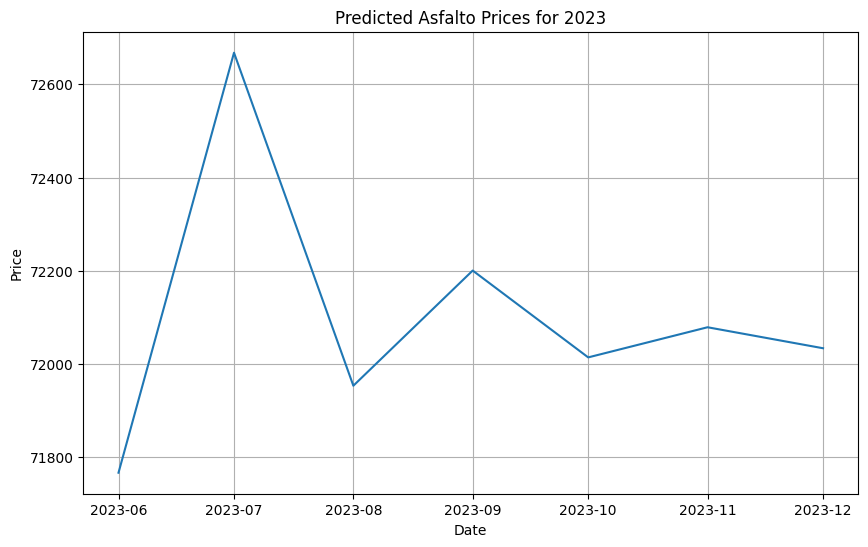

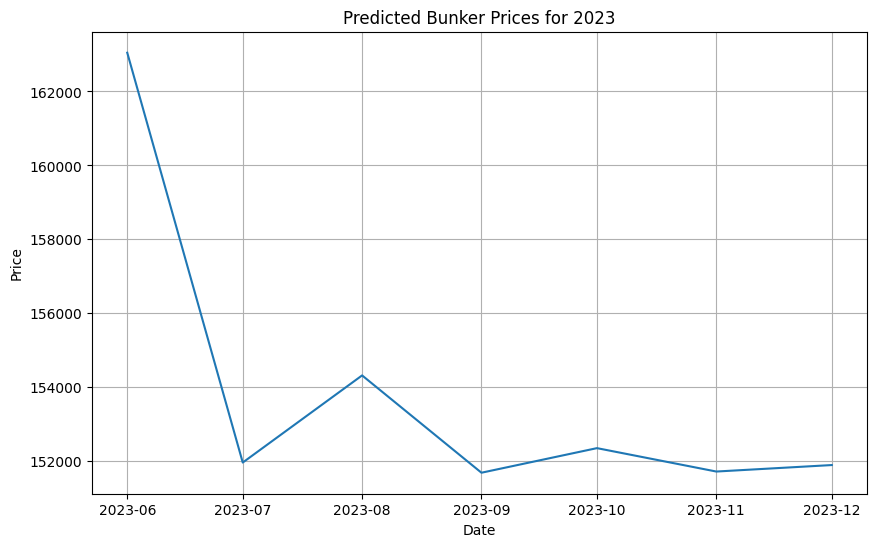

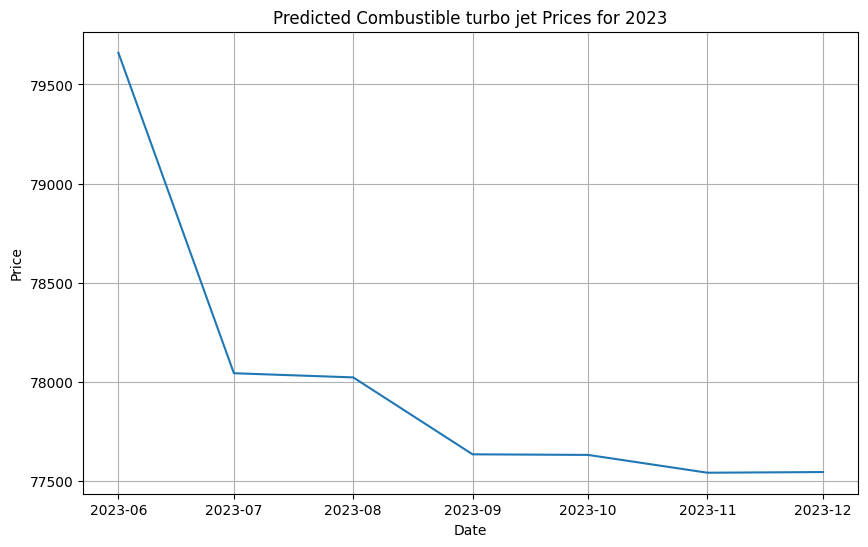

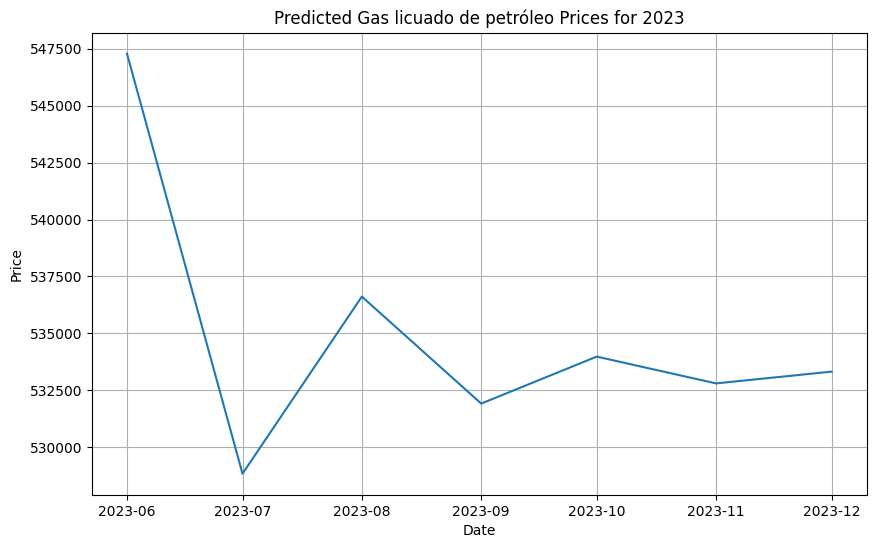

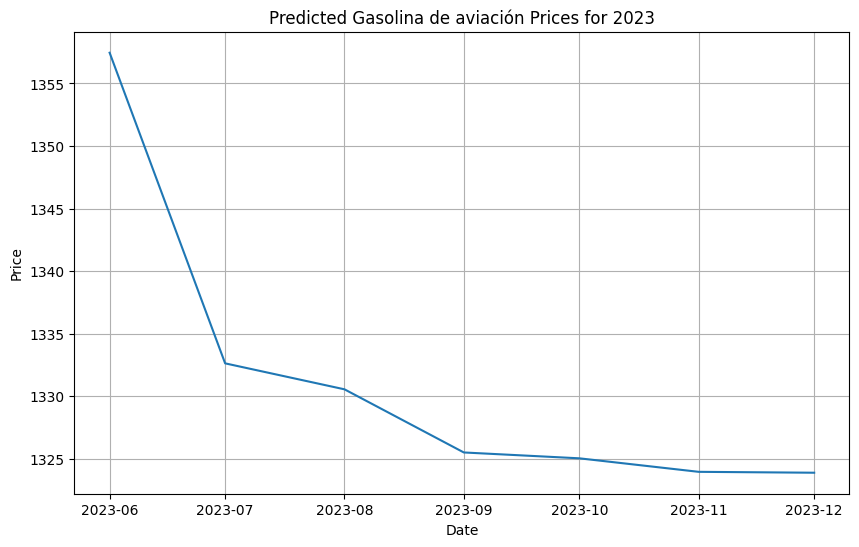

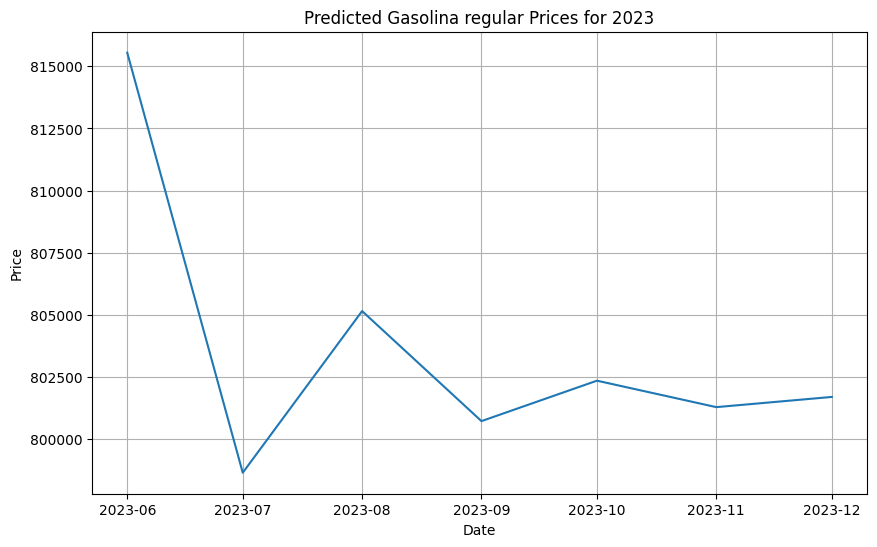

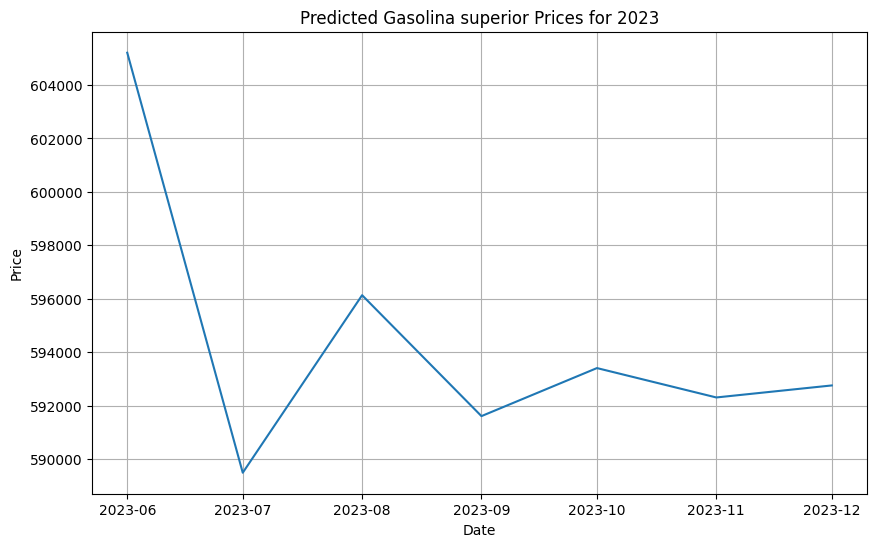

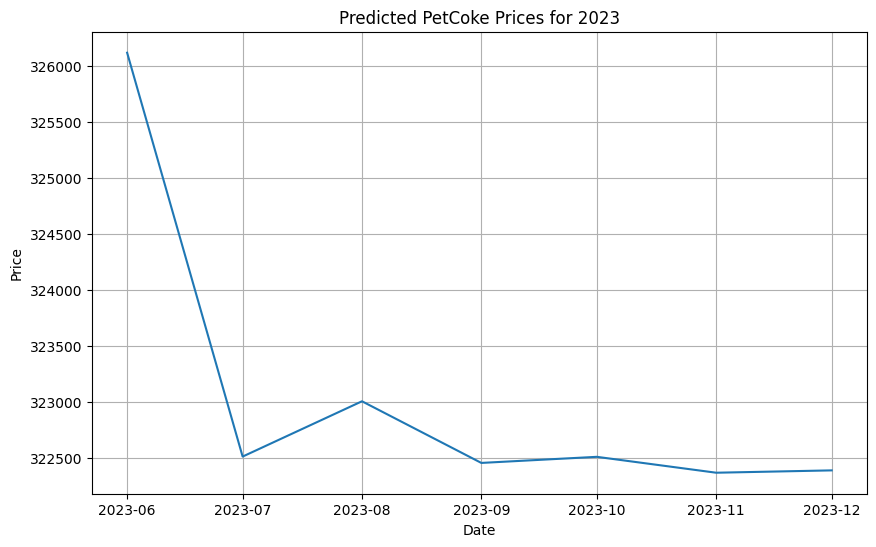

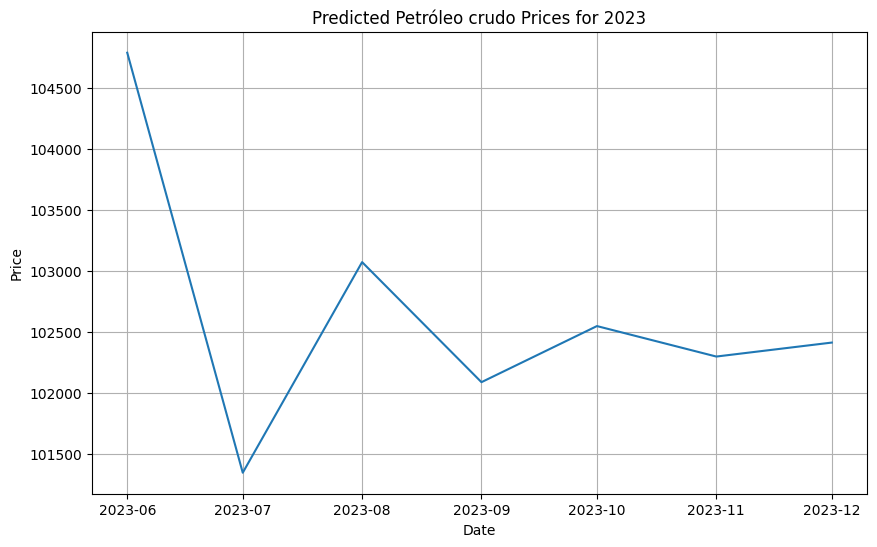

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('cons.csv')

# Drop columns_to_drop from data_2023
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre',
                   'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión', 'Kerosina']
data.drop(columns=columns_to_drop, inplace=True)

data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

# Filter data for January to May
data_2023 = data['2023-01-01':'2023-05-01']

# Split data into train and test sets
train_data = data_2023.iloc[:-1]
test_data = data_2023.iloc[-1:]

# Normalize data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Create sequences for training
sequence_length = 1
X_train = []
y_train = []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i+sequence_length])
    y_train.append(train_data_scaled[i+sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Build and train the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(data.columns))))
model.add(Dense(len(data.columns)))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200)

# Make predictions for the entire year
num_months = 7
X_test = [train_data_scaled[-sequence_length:]]
predictions_scaled = []
for _ in range(num_months):
    prediction_scaled = model.predict(np.array([X_test[-1]]))
    predictions_scaled.append(prediction_scaled)
    X_test.append(np.vstack((X_test[-1][1:], prediction_scaled)))

# Reshape predictions_scaled to 2D array
predictions_scaled = np.array(predictions_scaled).reshape(-1, len(data.columns))

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Create DataFrame with predicted values
num_months = 7  # Number of months to predict
predicted_dates = pd.date_range(start='2023-06-01', periods=num_months, freq='MS')
predictions_df = pd.DataFrame(data=predictions, columns=data_2023.columns)
predictions_df['Fecha'] = predicted_dates

# Plot predicted gas prices for each type of gas
gas_columns = ['Asfalto', 'Bunker', 'Combustible turbo jet', 'Gas licuado de petróleo',
               'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
               'PetCoke', 'Petróleo crudo']

for gas_column in gas_columns:
    plt.figure(figsize=(10, 6))
    plt.plot_date(predictions_df['Fecha'], predictions_df[gas_column], linestyle='solid', marker=None)
    plt.title(f'Predicted {gas_column} Prices for 2023')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

Durante 2023, se observaron variaciones significativas en los precios de los combustibles. En el caso del asfalto, los primeros cinco meses mostraron oscilaciones extremas en sus precios. De enero a marzo, hubo una disminución drástica en los precios, que luego aumentaron de marzo a abril. Las predicciones para el resto del año reflejan esta tendencia, indicando un pico alto en julio seguido de fluctuaciones hacia el final del año.

Por otro lado, los combustibles como Bunker, Turbo Jet, Gas licuado, Gas de aviación y las gasolinas regular y superior mostraron patrones más estables. Aunque presentan oscilaciones, no son tan pronunciadas. Por ejemplo, la gasolina regular tiene variaciones de alrededor de 15,000, sin cambios abruptos, sólo transiciones graduales. La Gasolina superior, con valores reales como 599501.29, 544144.00, entre otros, muestra en la gráfica una disminución desde su último precio registrado de 646221.20 hasta aproximadamente 585,000, lo cual es coherente con su comportamiento observado de enero a mayo.

En resumen, las tendencias de los precios de las gasolinas parecen estar dentro de un rango esperado basado en las observaciones de los primeros meses de 2023.

### Inciso 6. Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva normalidad”? 

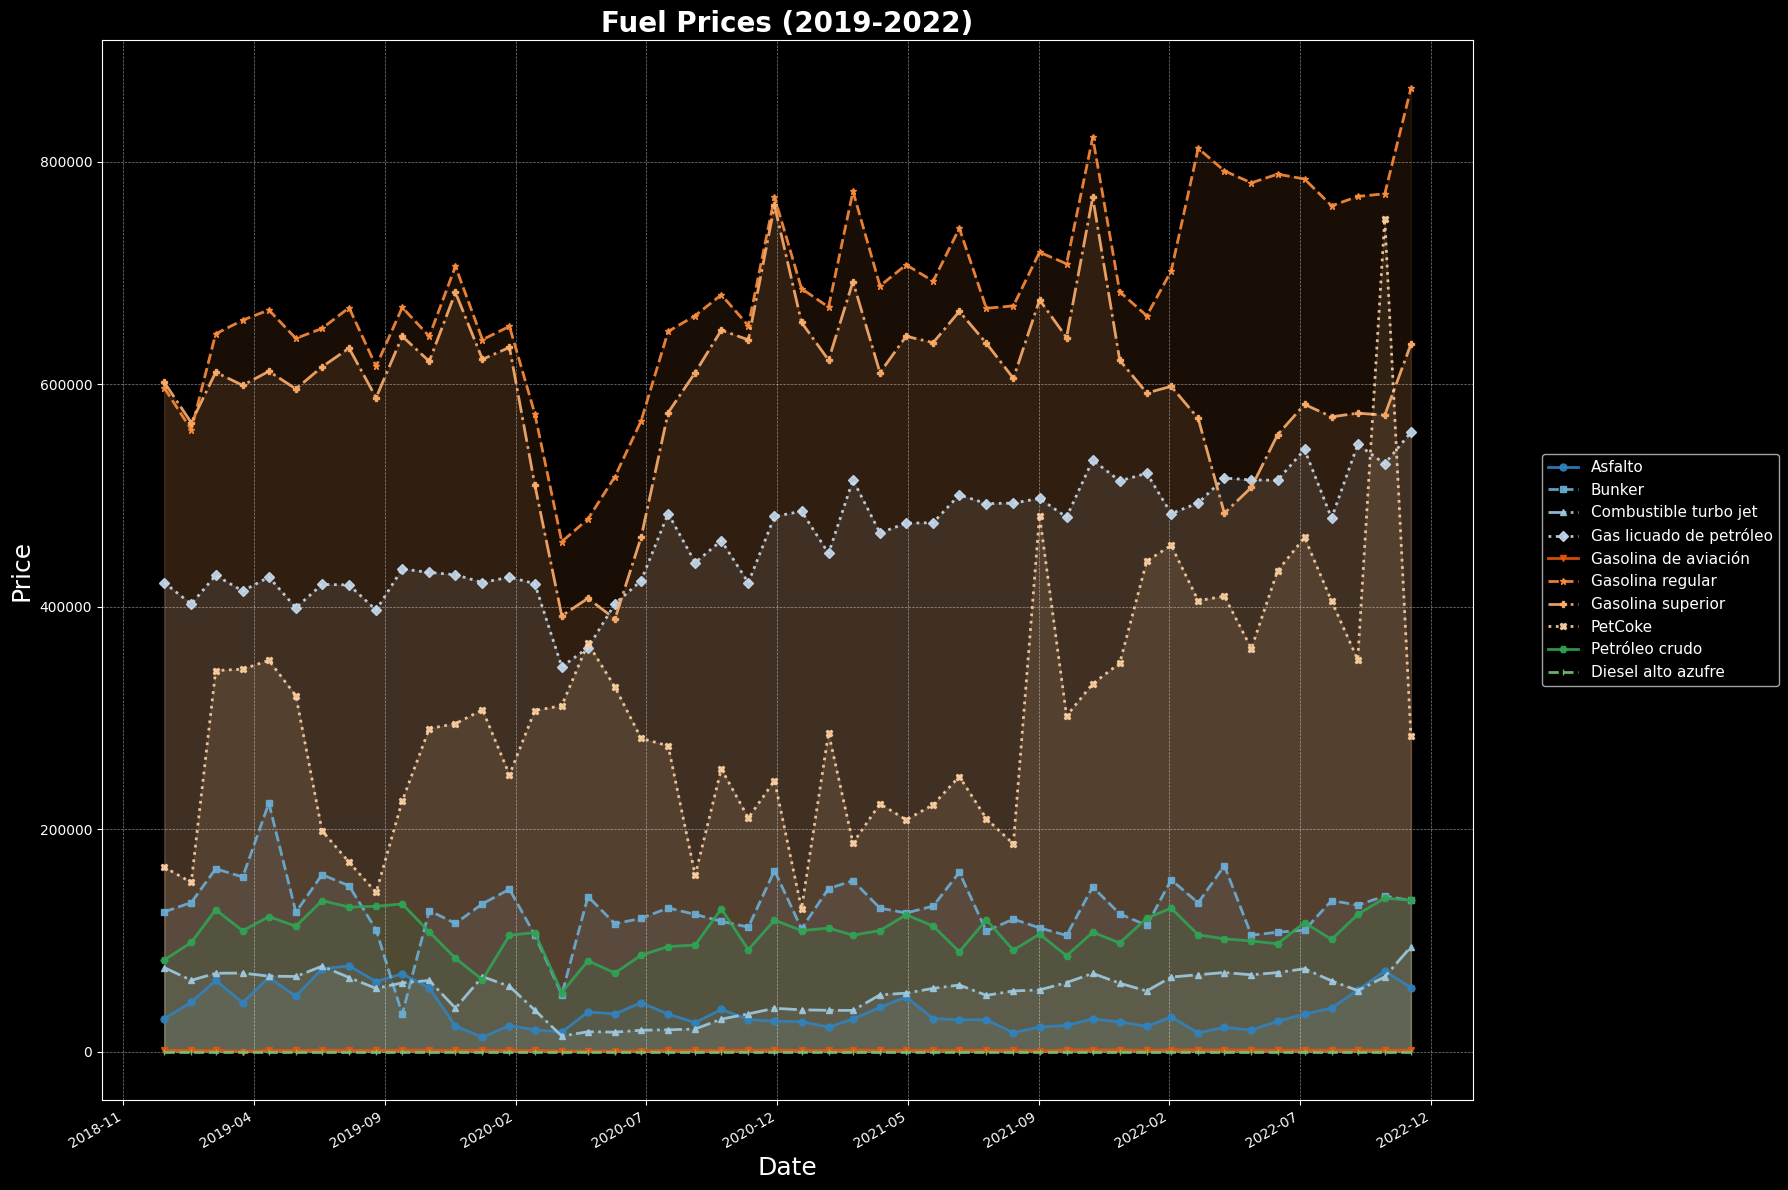

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def load_and_filter_data(file_path):
    """Load and filter data from the given CSV file."""
    
    # Columns to be considered
    relevant_columns = ['Fecha', 'Asfalto', 'Bunker', 'Combustible turbo jet', 
                        'Gas licuado de petróleo', 'Gasolina de aviación', 
                        'Gasolina regular', 'Gasolina superior', 'PetCoke', 
                        'Petróleo crudo', 'Diesel alto azufre']

    # Load dataset and filter columns
    df = pd.read_csv(file_path)
    df = df[relevant_columns]
    
    # Convert date column to datetime type and filter by date range
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df[(df['Fecha'] >= '2019-01-01') & (df['Fecha'] <= '2022-12-31')]
    
    return df

def corrected_enhanced_stylish_plot(df):
    """Aesthetically enhanced plotting function for all time series with corrected date format."""
    
    # All the columns except for the date
    time_series_columns = df.columns.drop('Fecha')
    
    # Using a broad color palette
    colors = plt.cm.tab20c.colors
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X', 'H', '|', '_']
    
    # Set a dark background style
    plt.style.use('dark_background')
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(18, 12))
    
    # Plot each time series with its respective color, line style and marker
    for idx, column in enumerate(time_series_columns):
        ax.plot(df['Fecha'], df[column], label=column, 
                color=colors[idx % len(colors)], 
                linewidth=2, 
                linestyle=line_styles[idx % len(line_styles)],
                marker=markers[idx % len(markers)],
                markersize=5,
                alpha=0.9)
        
        # Adding shaded area for each line
        ax.fill_between(df['Fecha'], 0, df[column], color=colors[idx % len(colors)], alpha=0.1)
        
    # Set title, labels, and legend
    ax.set_title('Fuel Prices (2019-2022)', fontsize=20, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=18, color='white')
    ax.set_ylabel('Price', fontsize=18, color='white')
    ax.legend(loc='center left', fontsize=11, bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
    
    # Corrected date formatting on the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Enhance grid and layout
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Set tick colors
    ax.tick_params(colors='white', which='both')
    
    fig.tight_layout()
    
    plt.show()

# Main execution
data_path = 'cons.csv'
filtered_data = load_and_filter_data(data_path)
corrected_enhanced_stylish_plot(filtered_data)
